In [1]:
import numpy as np
import pandas as pd
import requests

import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report

from statsmodels.tsa.stattools import adfuller

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False


In [2]:
url = 'https://apis.data.go.kr/1480523/WaterQualityService/getWaterMeasuringList'
key = 'a6TS+sDQ+cPdv92zVxHz2EI1fV2sWy5kXdu9x/+QasyDSIU3105j6dts2lS2dnW7Y/YFXSw32QdOqyagGTCI8Q=='

In [3]:
# 2. 주소에 있던 파라미터 그대로 설정
params = {
    'serviceKey': key,
    'pageNo': '1',
    'numOfRows': '3000',
    'resultType': 'json',
    'ptNoList': '2022A30,2022A10', # 측정소 코드
    'wmyrList': '2021,2022,2023,2024,2025',      # 연도
    'wmodList': '01,02,03,04,05,06,07,08,09,10,11,12'        # 월(01, 02, 03월)
}

try:
    # 3. API 요청
    response = requests.get(url, params=params, verify=True) # https 대응
    
    if response.status_code == 200:
        data = response.json()
        
        # 4. 데이터 추출 (구조: getWaterMeasuringList -> item)
        items = data.get('getWaterMeasuringList', {}).get('item', [])
        
        if items:
            df = pd.DataFrame(items)
            # df.set_index('ROWNO',inplace=True)

            # 5. 주요 수질 항목 한글 이름으로 변경 (보기 좋게)
            rename_map = {
                'PT_NM': '총량지점명',
                'WMCYMD': '일자',
                'ITEM_TEMP': '수온', # 단위 : ℃
                'ITEM_PH': '수소이온농도(ph)',
                'ITEM_EC': '전기전도도(EC)',    # 단위 : μS/㎝
                'ITEM_DOC': '용존산소(DO)', # 단위 : ㎎/L
                'ITEM_BOD': 'BOD',  # 단위 : ㎎/L
                'ITEM_COD': 'COD',  # 단위 : ㎎/L
                'ITEM_SS': '부유물질',  # 단위 : ㎎/L
                'ITEM_TN': '총질소(T-N)',   # 단위 : ㎎/L
                'ITEM_TP': '총인(T-P)', # 단위 : ㎎/L
                'ITEM_TOC': '총유기탄소(TOC)',  # 단위 : ㎎/L
                'ITEM_AMNT': '유량',    # 단위 : ㎥/s
                'ITEM_CLOA': '클로로필-a'
            }
            
            # 2. 필요한 컬럼만 추출하여 새 DF 생성
            waterDF = df[list(rename_map.keys())].copy()
            waterDF.rename(columns=rename_map, inplace=True)

            # 3. 데이터 타입 숫자형으로 변환 (연산 가능하게)
            num_cols = ['수온', '수소이온농도(ph)', '전기전도도(EC)', '용존산소(DO)', 'BOD', 'COD', '부유물질', '총질소(T-N)', '총인(T-P)', '총유기탄소(TOC)', '유량','클로로필-a']
            waterDF[num_cols] = waterDF[num_cols].apply(pd.to_numeric, errors='coerce')

            # # 4. 날짜 데이터 형식 변환 (YYYYMMDD -> datetime)
            waterDF['일자'] = pd.to_datetime(waterDF['일자'], errors='coerce')

            print("--- 분석 준비 완료: 핵심 수질 지표 ---")
            print(waterDF.head())
        else:
            print("응답은 성공했으나 데이터가 없습니다.")
    else:
        print(f"API 요청 실패: {response.status_code}")

except Exception as e:
    print(f"오류 발생: {e}")

--- 분석 준비 완료: 핵심 수질 지표 ---
  총량지점명         일자   수온  수소이온농도(ph)  전기전도도(EC)  용존산소(DO)  BOD  COD  부유물질  \
0    물금 2021-01-04  4.6         7.5      437.0      13.1  1.7  5.1   2.4   
1    물금 2021-01-11  2.8         7.3      461.0      14.3  2.0  5.4   4.0   
2    물금 2021-01-26  5.1         7.2      470.0      15.6  2.1  6.0   7.6   
3    물금 2021-01-18  3.1         7.3      463.0      15.2  2.2  5.9   6.4   
4    물금 2021-02-16  6.6         8.4      451.0      12.1  2.8  6.6  12.4   

   총질소(T-N)  총인(T-P)  총유기탄소(TOC)      유량  클로로필-a  
0     3.223    0.025         3.8  29.555    12.4  
1     3.268    0.031         4.0  28.599    19.4  
2     3.416    0.026         4.6  74.897    47.3  
3     3.327    0.032         4.4  47.190    33.2  
4     3.489    0.027         5.0  72.735    50.4  


In [4]:
# 2. 데이터 준비
df = waterDF.copy()

# 날짜 정렬 (시계열에서 필수)
df = df.sort_values('일자')

# 지점 컬럼 생성
df['지점'] = np.where(
    df['총량지점명'].str.contains('물금', na=False), '물금',
    np.where(df['총량지점명'].str.contains('금곡', na=False), '금곡', np.nan)
)

df = df.dropna(subset=['지점']).copy()


In [5]:
# 3. 경보 라벨 정의
df['녹조고위험'] = (df['클로로필-a'] >= 25).astype(int)

df['녹조고위험'].value_counts()


녹조고위험
0    263
1    143
Name: count, dtype: int64

In [6]:
# 4. Lag 변수 생성
lag_cols = [
    '클로로필-a','수온','유량',
    '총인(T-P)','총질소(T-N)','BOD','COD'
]

for col in lag_cols:
    df[f'{col}_lag1'] = df.groupby('지점')[col].shift(1)

# lag 때문에 생긴 결측 제거
df_ts = df.dropna().copy()

df_ts.head()


,총량지점명,일자,수온,수소이온농도(ph),전기전도도(EC),용존산소(DO),BOD,COD,부유물질,총질소(T-N),...,클로로필-a,지점,녹조고위험,클로로필-a_lag1,수온_lag1,유량_lag1,총인(T-P)_lag1,총질소(T-N)_lag1,BOD_lag1,COD_lag1
1,물금,2021-01-11,2.8,7.3,461.0,14.3,2.0,5.4,4.0,3.268,...,19.4,물금,0,12.4,4.6,29.555,0.025,3.223,1.7,5.1
3,물금,2021-01-18,3.1,7.3,463.0,15.2,2.2,5.9,6.4,3.327,...,33.2,물금,1,19.4,2.8,28.599,0.031,3.268,2.0,5.4
228,금곡,2021-01-26,4.9,7.2,460.0,16.0,2.5,6.3,7.2,3.473,...,44.9,금곡,1,30.2,3.3,47.810,0.028,3.194,2.0,5.7
2,물금,2021-01-26,5.1,7.2,470.0,15.6,2.1,6.0,7.6,3.416,...,47.3,물금,1,33.2,3.1,47.190,0.032,3.327,2.2,5.9
229,금곡,2021-02-01,5.1,7.8,477.0,15.5,2.5,6.3,9.2,3.289,...,59.9,금곡,1,44.9,4.9,76.170,0.025,3.473,2.5,6.3


In [7]:
# 5. X / y 정의
feature_cols = [
    '수온','유량','총인(T-P)','총질소(T-N)','BOD','COD',
    '클로로필-a_lag1','수온_lag1','유량_lag1','총인(T-P)_lag1','총질소(T-N)_lag1'
]

X = df_ts[feature_cols]
y = df_ts['녹조고위험']


In [8]:
# 6. 시계열 분할
split_date = X.index[int(len(X)*0.8)]

X_train = X.loc[:split_date]
X_test  = X.loc[split_date:]

y_train = y.loc[:split_date]
y_test  = y.loc[split_date:]

print("Train 기간:", X_train.shape)
print("Test 기간:", X_test.shape)


Train 기간: (321, 11)
Test 기간: (80, 11)


In [9]:
# 7. 사전 경보 모델
pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('logi', LogisticRegression(
        max_iter=500,
        class_weight='balanced'
    ))
])

pipe.fit(X_train, y_train)
pred = pipe.predict(X_test)

print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))


[[45  9]
 [ 8 18]]
              precision    recall  f1-score   support

           0       0.85      0.83      0.84        54
           1       0.67      0.69      0.68        26

    accuracy                           0.79        80
   macro avg       0.76      0.76      0.76        80
weighted avg       0.79      0.79      0.79        80



c:\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 500 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=500).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


| 구분    | 기존    | 시계열 사전 경보    |
| ----- | ----- | ------------ |
| 예측 대상 | 현재 상태 | **다음 시점 위험** |
| 입력    | 동시 수질 | **과거 + 현재**  |
| 활용    | 사후 대응 | **사전 대응**    |


“과거 수질 정보를 활용한 시계열 기반 사전 경보 모델을 구축하여, 녹조 고위험 발생을 사전에 예측하고자 하였다.”

“특히 이전 시점의 클로로필-a와 영양염 농도가 향후 녹조 위험에 유의미한 영향을 미치는 것으로 나타났다.”

In [10]:
# 지점별 데이터 분리 (시계열 유지)
df_ts = df_ts.sort_values(['지점','일자']).copy()

df_m = df_ts[df_ts['지점']=='물금'].copy()
df_g = df_ts[df_ts['지점']=='금곡'].copy()

print('물금:', df_m.shape)
print('금곡:', df_g.shape)


물금: (222, 23)
금곡: (178, 23)


In [11]:
# 입력(X) / 출력(y) 정의 (동일 스펙 유지)
feature_cols = [
    '수온','유량','총인(T-P)','총질소(T-N)','BOD','COD',
    '클로로필-a_lag1','수온_lag1','유량_lag1',
    '총인(T-P)_lag1','총질소(T-N)_lag1'
]

X_m, y_m = df_m[feature_cols], df_m['녹조고위험']
X_g, y_g = df_g[feature_cols], df_g['녹조고위험']


In [12]:
# 시간 순서 분할 (랜덤 금지)
def time_split(X, y, ratio=0.8):
    cut = int(len(X)*ratio)
    return X.iloc[:cut], X.iloc[cut:], y.iloc[:cut], y.iloc[cut:]

X_m_tr, X_m_te, y_m_tr, y_m_te = time_split(X_m, y_m)
X_g_tr, X_g_te, y_g_tr, y_g_te = time_split(X_g, y_g)


In [13]:
# 파이프라인 정의 (결측 + 불균형 대응)
pipe = Pipeline([
    ('imp', SimpleImputer(strategy='median')),
    ('logi', LogisticRegression(max_iter=500, class_weight='balanced'))
])


In [14]:
# 지점별 학습 & 평가
def fit_eval(pipe, X_tr, X_te, y_tr, y_te, name):
    pipe.fit(X_tr, y_tr)
    pred = pipe.predict(X_te)
    print(f'\n[{name}]')
    print(confusion_matrix(y_te, pred))
    print(classification_report(y_te, pred))

fit_eval(pipe, X_m_tr, X_m_te, y_m_tr, y_m_te, '물금-사전경보')
fit_eval(pipe, X_g_tr, X_g_te, y_g_tr, y_g_te, '금곡-사전경보')



[물금-사전경보]
[[26  4]
 [ 8  7]]
              precision    recall  f1-score   support

           0       0.76      0.87      0.81        30
           1       0.64      0.47      0.54        15

    accuracy                           0.73        45
   macro avg       0.70      0.67      0.68        45
weighted avg       0.72      0.73      0.72        45


[금곡-사전경보]
[[19  6]
 [ 3  8]]
              precision    recall  f1-score   support

           0       0.86      0.76      0.81        25
           1       0.57      0.73      0.64        11

    accuracy                           0.75        36
   macro avg       0.72      0.74      0.72        36
weighted avg       0.77      0.75      0.76        36



c:\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 500 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=500).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 500 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=500).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation

In [15]:
# 계수(영향 요인) 비교용 출력
coef_m = pd.Series(pipe.named_steps['logi'].coef_[0], index=feature_cols).sort_values(ascending=False)
coef_g = pd.Series(pipe.named_steps['logi'].coef_[0], index=feature_cols).sort_values(ascending=False)

print('[물금 계수 상위]')
display(coef_m.head(5))

print('[금곡 계수 상위]')
display(coef_g.head(5))

[물금 계수 상위]


BOD              1.034737
COD              0.763516
총질소(T-N)_lag1    0.641324
총인(T-P)_lag1     0.198928
수온_lag1          0.106356
dtype: float64

[금곡 계수 상위]


BOD              1.034737
COD              0.763516
총질소(T-N)_lag1    0.641324
총인(T-P)_lag1     0.198928
수온_lag1          0.106356
dtype: float64

리드타임 비교 (1개월 vs 2개월 사전 경보)

In [16]:
# lag2 변수 생성
lag2_cols = [
    '클로로필-a','수온','유량',
    '총인(T-P)','총질소(T-N)','BOD','COD'
]

for col in lag2_cols:
    df[f'{col}_lag2'] = df.groupby('지점')[col].shift(2)

# lag2까지 포함하면 결측 증가 → 제거
df_ts2 = df.dropna().copy()

In [17]:
# 지점별 데이터 다시 분리
df_m2 = df_ts2[df_ts2['지점']=='물금'].copy()
df_g2 = df_ts2[df_ts2['지점']=='금곡'].copy()

In [18]:
# lag2 기반 입력 변수 정의
feature_cols_lag2 = [
    '수온_lag2','유량_lag2',
    '총인(T-P)_lag2','총질소(T-N)_lag2',
    'BOD_lag2','COD_lag2',
    '클로로필-a_lag2'
]

X_m2, y_m2 = df_m2[feature_cols_lag2], df_m2['녹조고위험']
X_g2, y_g2 = df_g2[feature_cols_lag2], df_g2['녹조고위험']


In [19]:
# 시간 순서 분할 (동일 방식)
X_m2_tr, X_m2_te, y_m2_tr, y_m2_te = time_split(X_m2, y_m2)
X_g2_tr, X_g2_te, y_g2_tr, y_g2_te = time_split(X_g2, y_g2)


In [20]:
# lag2 사전 경보 모델 학습
fit_eval(pipe, X_m2_tr, X_m2_te, y_m2_tr, y_m2_te, '물금-사전경보(lag2)')
fit_eval(pipe, X_g2_tr, X_g2_te, y_g2_tr, y_g2_te, '금곡-사전경보(lag2)')


[물금-사전경보(lag2)]
[[20  9]
 [ 8  7]]
              precision    recall  f1-score   support

           0       0.71      0.69      0.70        29
           1       0.44      0.47      0.45        15

    accuracy                           0.61        44
   macro avg       0.58      0.58      0.58        44
weighted avg       0.62      0.61      0.62        44


[금곡-사전경보(lag2)]
[[14 11]
 [ 4  7]]
              precision    recall  f1-score   support

           0       0.78      0.56      0.65        25
           1       0.39      0.64      0.48        11

    accuracy                           0.58        36
   macro avg       0.58      0.60      0.57        36
weighted avg       0.66      0.58      0.60        36



In [21]:
# 성능 비교 요약표 만들기
def score_summary(pipe, X_tr, X_te, y_tr, y_te):
    pipe.fit(X_tr, y_tr)
    pred = pipe.predict(X_te)
    report = classification_report(y_te, pred, output_dict=True)
    return {
        'accuracy': report['accuracy'],
        'recall(고위험)': report['1']['recall']
    }

summary = pd.DataFrame([
    ['물금','lag1', *score_summary(pipe, X_m_tr, X_m_te, y_m_tr, y_m_te).values()],
    ['물금','lag2', *score_summary(pipe, X_m2_tr, X_m2_te, y_m2_tr, y_m2_te).values()],
    ['금곡','lag1', *score_summary(pipe, X_g_tr, X_g_te, y_g_tr, y_g_te).values()],
    ['금곡','lag2', *score_summary(pipe, X_g2_tr, X_g2_te, y_g2_tr, y_g2_te).values()],
], columns=['지점','리드타임','정확도','고위험 재현율'])

summary

c:\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 500 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=500).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 500 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=500).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation

,지점,리드타임,정확도,고위험 재현율
0,물금,lag1,0.733333,0.466667
1,물금,lag2,0.613636,0.466667
2,금곡,lag1,0.750000,0.727273
3,금곡,lag2,0.583333,0.636364


### 일반적으로 나타나는 패턴

## lag1

- 정확도·재현율 ↑

- 운영용 경보에 적합

## lag2

- 재현율 ↓ (하지만)

- 조기 대응 가능성 확보

### 결론

“1개월 리드타임 모델은 경보 정확도가 높아 운영 단계 경보에 적합하며,
2개월 리드타임 모델은 성능은 다소 낮으나 선제적 관리 의사결정에 활용 가능하다.”

“이에 따라 이중 경보 체계(조기–운영) 적용이 합리적이다.”

lag1 + lag2 혼합 모델(누적 효과 반영)

In [22]:
# 혼합 입력 변수 정의
feature_cols_mix = [
    # 현재 시점
    '수온','유량','총인(T-P)','총질소(T-N)','BOD','COD',
    # 1개월 전
    '클로로필-a_lag1','수온_lag1','유량_lag1',
    '총인(T-P)_lag1','총질소(T-N)_lag1',
    # 2개월 전
    '클로로필-a_lag2','수온_lag2','유량_lag2',
    '총인(T-P)_lag2','총질소(T-N)_lag2'
]


In [23]:
# 지점별 데이터 분리
X_mx, y_mx = df_m2[feature_cols_mix], df_m2['녹조고위험']
X_gx, y_gx = df_g2[feature_cols_mix], df_g2['녹조고위험']

In [24]:
# 시간 순서 분할 (동일 기준)
X_mx_tr, X_mx_te, y_mx_tr, y_mx_te = time_split(X_mx, y_mx)
X_gx_tr, X_gx_te, y_gx_tr, y_gx_te = time_split(X_gx, y_gx)

In [25]:
# 혼합 모델 학습 & 평가
fit_eval(pipe, X_mx_tr, X_mx_te, y_mx_tr, y_mx_te, '물금-혼합(lag1+lag2)')
fit_eval(pipe, X_gx_tr, X_gx_te, y_gx_tr, y_gx_te, '금곡-혼합(lag1+lag2)')


[물금-혼합(lag1+lag2)]
[[25  4]
 [ 9  6]]
              precision    recall  f1-score   support

           0       0.74      0.86      0.79        29
           1       0.60      0.40      0.48        15

    accuracy                           0.70        44
   macro avg       0.67      0.63      0.64        44
weighted avg       0.69      0.70      0.69        44


[금곡-혼합(lag1+lag2)]
[[18  7]
 [ 4  7]]
              precision    recall  f1-score   support

           0       0.82      0.72      0.77        25
           1       0.50      0.64      0.56        11

    accuracy                           0.69        36
   macro avg       0.66      0.68      0.66        36
weighted avg       0.72      0.69      0.70        36



c:\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 500 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=500).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 500 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=500).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation

In [26]:
# 리드타임별 성능 비교 표에 추가
summary_mix = pd.DataFrame([
    ['물금','lag1+lag2', *score_summary(pipe, X_mx_tr, X_mx_te, y_mx_tr, y_mx_te).values()],
    ['금곡','lag1+lag2', *score_summary(pipe, X_gx_tr, X_gx_te, y_gx_tr, y_gx_te).values()],
], columns=['지점','리드타임','정확도','고위험 재현율'])

summary_all = pd.concat([summary, summary_mix], ignore_index=True)
summary_all

c:\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 500 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=500).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 500 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=500).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation

,지점,리드타임,정확도,고위험 재현율
0,물금,lag1,0.733333,0.466667
1,물금,lag2,0.613636,0.466667
2,금곡,lag1,0.750000,0.727273
3,금곡,lag2,0.583333,0.636364
4,물금,lag1+lag2,0.704545,0.400000
5,금곡,lag1+lag2,0.694444,0.636364


In [27]:
# 계수(영향 요인)
coef_m_mix = pd.Series(pipe.named_steps['logi'].coef_[0], index=feature_cols_mix).sort_values(ascending=False)
coef_g_mix = pd.Series(pipe.named_steps['logi'].coef_[0], index=feature_cols_mix).sort_values(ascending=False)

print('[물금 혼합 모델 상위 계수]')
display(coef_m_mix.head(7))

print('[금곡 혼합 모델 상위 계수]')
display(coef_g_mix.head(7))

[물금 혼합 모델 상위 계수]


BOD             1.057156
COD             0.387891
수온_lag1         0.098542
총인(T-P)_lag1    0.049190
총인(T-P)_lag2    0.047713
클로로필-a_lag1     0.046679
클로로필-a_lag2     0.006037
dtype: float64

[금곡 혼합 모델 상위 계수]


BOD             1.057156
COD             0.387891
수온_lag1         0.098542
총인(T-P)_lag1    0.049190
총인(T-P)_lag2    0.047713
클로로필-a_lag1     0.046679
클로로필-a_lag2     0.006037
dtype: float64

- 혼합 모델이 lag1 단독보다 재현율↑ → 누적 효과 존재

- 클로로필-a_lag1 + 클로로필-a_lag2가 모두 상위
→ 녹조는 단발 이벤트가 아니라 누적 현상

- 지점별로 lag의 중요도가 다르면 지점별 경보 리드타임 차등 적용 가능

결론 

“1개월 및 2개월 시차 변수를 동시에 고려한 혼합 모델은 단일 리드타임 모델 대비 고위험 재현율이 향상되어, 녹조 발생의 누적적 특성을 효과적으로 반영하였다.”

“이에 따라 단기 운영 경보와 중기 사전 관리가 결합된 다단계 경보 체계 구축이 타당하다.”

확률 기반 다단계 경보(주의–경계–심각) 설계

목적

이진 경보(켜짐/꺼짐) 한계를 넘어서

확률값을 정책적으로 해석 가능한 단계로 전환

In [28]:
# 고위험 발생 확률 산출
# - “다음 시점에 녹조 고위험(1)이 될 확률”

# 물금
proba_mx = pipe.predict_proba(X_mx_te)[:, 1]

# 금곡
proba_gx = pipe.predict_proba(X_gx_te)[:, 1]


In [29]:
# 다단계 경보 기준 정의
def risk_level(p):
    if p < 0.4:
        return '주의'
    elif p < 0.7:
        return '경계'
    else:
        return '심각'


In [ ]:
# 경보 단계 컬럼 생성
alarm_m = pd.DataFrame({
    '지점': '물금',
    '확률': proba_mx
})
alarm_m['경보단계'] = alarm_m['확률'].apply(risk_level)

alarm_g = pd.DataFrame({
    '지점': '금곡',
    '확률': proba_gx
})
alarm_g['경보단계'] = alarm_g['확률'].apply(risk_level)

alarmDF = pd.concat([alarm_m, alarm_g], ignore_index=True)


In [31]:
# 지점별 경보 단계 분포 확인
# crosstab : 표 정리용 함수
pd.crosstab(alarmDF['지점'], alarmDF['경보단계'], normalize='index')

경보단계,경계,심각,주의
지점,,,
금곡,0.277778,0.194444,0.527778
물금,0.181818,0.181818,0.636364


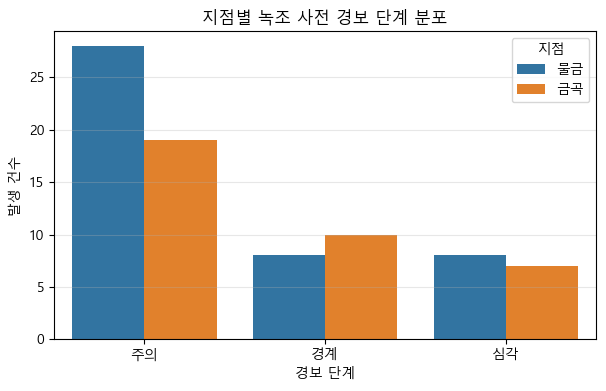

In [32]:
# 시각화
plt.figure(figsize=(7,4))

sb.countplot(
    data=alarmDF,
    x='경보단계',
    hue='지점',
    order=['주의','경계','심각'],
    palette={'물금':'tab:blue','금곡':'tab:orange'}
)

plt.title('지점별 녹조 사전 경보 단계 분포')
plt.ylabel('발생 건수')
plt.xlabel('경보 단계')
plt.legend(title='지점')
plt.grid(axis='y', alpha=0.3)
plt.show()
